# Load & save dataset features

- Load the metadata of the FMA dataset
- Keep only tracks of specified genres
- Keep only tracks with top popularity
- Create the adjacency matrix
- Keep the biggest connected component if not fully connected

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython.display as ipd
from scipy.spatial.distance import pdist, squareform
import math
import collections

In [2]:
# gather the dataset

path = '../fma_metadata/'

tracks = pd.read_csv(path+'tracks.csv', index_col=0, header=[0, 1])
echonest = pd.read_csv(path+'echonest.csv', index_col=0, header=[0, 1, 2])

# Features selected and extracted
audio_features = echonest.echonest.audio_features[['acousticness','danceability','instrumentalness',\
                                                   'energy','liveness','tempo','speechiness']]
temporal_features = echonest.echonest.temporal_features
genres = tracks.track[['genres', 'genre_top']]
artists_data = echonest.echonest.social_features[['artist_discovery']].copy()\
                /max(echonest.echonest.social_features.artist_discovery) # add a dimension for artists
popularity = tracks.track[['listens']] # to filter by most listened tracks

# Show all the genres of music
features_and_genres = audio_features.merge(genres, on='track_id')\
                                    .merge(artists_data, on='track_id')\
                                    .merge(popularity, on='track_id')\
                                    .merge(temporal_features, on='track_id')

features_and_genres.genre_top.value_counts()

Rock                   3892
Electronic             2170
Hip-Hop                 910
Folk                    874
Old-Time / Historic     357
Pop                     346
Classical               265
Jazz                    241
International           133
Instrumental             84
Blues                    66
Experimental             17
Name: genre_top, dtype: int64

We keep only the tracks with a minimum of popularity (number of times it was listened to) relatively to each genre.

In [3]:
# Define here how much of the data is cropped:
quantile_listens = 0.9

popu_quantile = features_and_genres[['genre_top', 'listens']].groupby(by='genre_top')\
                    .quantile([quantile_listens])\
                    .reset_index()[['genre_top', 'listens']].rename(columns = {'listens':'threshold'})
temp = pd.merge(features_and_genres.reset_index(), popu_quantile, on='genre_top')\
         .set_index('track_id')
features_reduced = temp[temp.listens > temp.threshold].drop(columns=['listens','threshold'])
features_reduced.genre_top.value_counts()

Rock                   389
Electronic             217
Hip-Hop                 91
Folk                    88
Old-Time / Historic     36
Pop                     35
Classical               27
Jazz                    24
International           14
Instrumental             9
Blues                    7
Experimental             2
Name: genre_top, dtype: int64

Comparison between how many tracks we have left compared to before:

In [4]:
features_reduced.genre_top.describe()

count      939
unique      12
top       Rock
freq       389
Name: genre_top, dtype: object

In [5]:
features_and_genres.genre_top.describe()

count     9355
unique      12
top       Rock
freq      3892
Name: genre_top, dtype: object

# Select the genres that you want in your graph 
Add them in the "selected genres" down below

In [6]:
selected_genres = ['Rock', 'Electronic', 'Hip-Hop', 'Pop', 'Classical', 'Jazz', 'International']

features_selected_genres = features_reduced[features_reduced.genre_top.isin(selected_genres)]

features = features_selected_genres.drop(columns=['genres','genre_top'])
# keep only numerical data now that the selection according to genres is done
features.head()

,acousticness,danceability,instrumentalness,energy,liveness,tempo,speechiness,artist_discovery,000,001,...,214,215,216,217,218,219,220,221,222,223
track_id,,,,,,,,,,,,,,,,,,,,,
694,0.145843,0.405345,1.180000e-08,0.842616,0.066630,98.315,0.563464,0.593997,0.653637,0.620206,...,-1.967173,6.949185,0.237893,0.193265,0.046328,0.06186,4.74884,4.68698,10.206572,175.532974
695,0.311324,0.291688,4.401070e-01,0.810857,0.362146,166.200,0.106019,0.593997,0.783247,0.660946,...,-3.174006,26.809431,0.222318,0.190885,0.011988,0.07215,0.93370,0.86155,2.050020,7.941118
4682,0.279977,0.415620,8.970278e-01,0.770144,0.361718,173.992,0.110480,0.628662,0.683673,0.682119,...,-3.399264,19.230091,0.227399,0.185645,0.016518,0.06839,3.17565,3.10726,9.410542,190.495132
4685,0.212457,0.383114,9.049935e-01,0.605240,0.219908,164.045,0.053686,0.628662,0.678482,0.720425,...,-3.259778,10.232733,0.325047,0.277550,0.085027,0.06354,3.30281,3.23927,5.146529,36.030987
5268,0.415893,0.856297,7.895851e-01,0.420439,0.074111,150.048,0.415442,0.628662,0.486710,0.710456,...,-0.718682,0.386437,0.229049,0.203170,0.038602,0.06984,5.87107,5.80123,21.560978,600.576233


In [7]:
# Split features to have echonest and a more classic feature dataframe

echonest = features.drop(columns = ['acousticness','danceability','instrumentalness','artist_discovery'])
features = features[['acousticness','danceability','instrumentalness','artist_discovery']]

In [8]:
distances = pdist(features.values, metric='euclidean')
# weights computed with a kernel and removing all the weights below threshold
threshold = 0.885

# Gaussian kernel: 
kernel_width = distances.mean()
weights = np.exp(-distances**2 / kernel_width**2)
weights[weights < threshold] = 0
adjacency = squareform(weights)# the adjacency matrix
n_nodes = len(features)

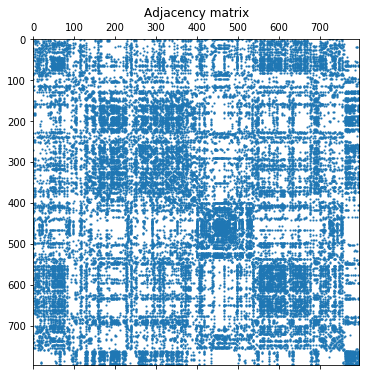

In [9]:
# plot of the adjacency matrix
figure1 = plt.figure(figsize=(6, 6))
plt.spy(adjacency, markersize=1, figure = figure1)
plt.title('Adjacency matrix')
plt.show()

In [10]:
# converts a matrix to a list
def matrix_to_list(matrix):
    adj_list = {}
    for i, node in enumerate(matrix):
        connected_nodes = []
        for neighbour_id, neighbour_w in enumerate(node):
            if neighbour_w >0:
                connected_nodes.append(neighbour_id)
        adj_list[i] = connected_nodes
    return adj_list

In [11]:
def connected_graph(adjacency):
    """Determines whether a graph is connected.
    
    Parameters
    ----------
    adjacency: numpy array
        The (weighted) adjacency matrix of a graph.
    
    Returns
    -------
    bool
        True if the graph is connected, False otherwise.
    """

    adjacency_list = matrix_to_list(adjacency)
    
    visited = set()
    visited.add(0)
    queue = collections.deque([0])
    #collections is a faster queue than a list
    
    while queue:
        node = queue.popleft()
        for neighbour in adjacency_list[node]:
            if neighbour not in visited:
                visited.add(neighbour)
                queue.append(neighbour)
        
    return (len(adjacency)==len(visited))

In [12]:
connected_graph(adjacency)

False

In [13]:
def find_components(adjacency):
    """Find the connected components of a graph.
    
    Parameters
    ----------
    adjacency: numpy array
        The (weighted) adjacency matrix of a graph.
    
    Returns
    -------
    list of numpy arrays
        A list of adjacency matrices, one per connected component.
    """
    
    # Your code here.
    
    components = []
    comp_ids = []
    start = 0
    if connected_graph(adjacency):
        return adjacency
    else:
        adjacency_list = matrix_to_list(adjacency)
        visited = set([])

        while len(adjacency)!=len(visited)+1:
            comp_visited = set([])
            comp_visited.add(start)
            visited.add(start)
            queue = collections.deque([start])
            #collections is a faster queue than a list

            while queue:
                node = queue.popleft()
                for neighbour in adjacency_list[node]:
                    if neighbour not in visited:
                        comp_visited.add(neighbour)
                        visited.add(neighbour)
                        queue.append(neighbour)
            comp_visited = list(comp_visited)
            comp_ids.append(comp_visited)
            components.append((adjacency[comp_visited,:])[:,comp_visited])
            while start in visited:
                start += 1
        return components, comp_ids

In [14]:
# keeps only the biggest component in order to have a connected graph
if connected_graph(adjacency) is False:
    # compute the connected components
    components, comp_ids = find_components(adjacency)
    # select the biggest components
    length = 0
    index = 0
    for i in range(len(components)):
        if(len(components[i]) > length):
            length = len(components[i])
            index = i
    new_adjacency = components[index]
    new_ids = comp_ids[index]
    new_features = features[features.index.isin(features.index[new_ids])].reset_index()
    new_echonest = echonest[echonest.index.isin(echonest.index[new_ids])].reset_index()
else:
    new_adjacency = adjacency
    new_features = features.reset_index() 
    new_echonest = echonest.reset_index()
# add the track_id as a column, the new index will be the same as the nodes

In [17]:
# computes the signals on which the smoothness will be computed: mean and average of the temporal features, energy, liveness,
# tempo and speechness of the tracks in the dataset
echonest = pd.DataFrame()
echonest = pd.concat([new_echonest[['track_id']],\
                        pd.DataFrame(np.array(new_echonest.drop(columns = ['track_id','energy','liveness','tempo', 'speechiness']).std(1)),columns = ['standard_dev']),\
                        pd.DataFrame(np.array(new_echonest.drop(columns = ['track_id','energy','liveness','tempo', 'speechiness']).std(1)),columns = ['average']),\
                        new_echonest[['energy','liveness','tempo','speechiness']]],\
                       axis = 1, sort=False)

In [18]:
# saves
new_features.to_csv('new_out_features.csv', index=False)
echonest.to_csv('new_out_echonest.csv', index=False)
np.save('new_adjacency', new_adjacency)

In [19]:
# create new dataframe listing all tracks' artist names and song titles
# index corresponds to node number of the graph
all_artists_titles = pd.merge(tracks.artist[['name']].reset_index(),\
                             tracks.track[['title']].reset_index(), on='track_id')
artists_titles = pd.merge(new_features[['track_id']], all_artists_titles, on='track_id')\
                        .merge(genres[['genre_top']].reset_index(), on='track_id')\
                        .rename(columns={'name':'artist','genre_top':'genre'})

artists_titles.to_csv('artists_titles.csv', index=False)
artists_titles.head()

,track_id,artist,title,genre
0,694,Food For Animals,Planet Say (featuring Faust),Hip-Hop
1,695,Food For Animals,Elephants,Hip-Hop
2,4682,Dälek,Asylum (Permanent Underclass),Hip-Hop
3,4685,Dälek,Ever Somber,Hip-Hop
4,5268,Dälek,3 Rocks Blessed,Hip-Hop


Original adjacency matrix stats:

In [20]:
n_nodes = np.size(adjacency,1) # the number of nodes in the network
n_edges = sum(sum(adjacency!=0))/2 # number of edges in the network
print(n_nodes)
print(n_edges)

797
16786.0


Biggest connected component stats:

In [21]:
n_nodes = np.size(new_adjacency,1) # the number of nodes in the network
n_edges = sum(sum(new_adjacency!=0))/2 # number of edges in the network
print(n_nodes)
print(n_edges)

795
16786.0


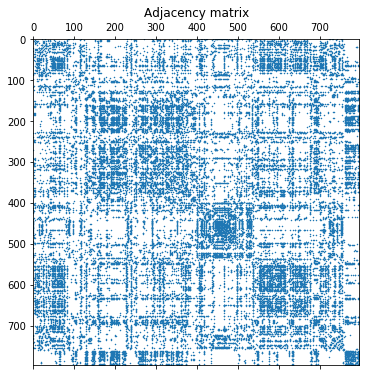

In [22]:
figure2 = plt.figure(figsize=(6, 6))
plt.spy(adjacency, markersize=0.5, figure=figure2)
plt.title('Adjacency matrix')
plt.show()
figure2.savefig("adja.png")